## Assignment: $k$ Means Clustering

## **Do two questions.**

`! git clone https://www.github.com/DS3001/kmc`

**Q1.** This question is a case study for $k$ means clustering.

1. Load the `airbnb_hw.csv` data. Clean `Price` along with `Beds`, `Number of Reviews`, and `Review Scores Rating`.

In [1]:
# import all necessary packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans

# read airbnb data
adf = pd.read_csv('./data/airbnb_hw.csv',low_memory=False)

In [26]:
adf.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [27]:
adf.shape

(30478, 13)

In [2]:
adf = adf.loc[:,['Price','Beds','Number Of Reviews','Review Scores Rating']]

In [29]:
adf.describe()

,Beds,Number Of Reviews,Review Scores Rating
count,30393.000000,30478.000000,22155.000000
mean,1.530089,12.018735,91.993230
std,1.015359,21.980703,8.850373
min,0.000000,0.000000,20.000000
25%,1.000000,0.000000,89.000000
50%,1.000000,3.000000,94.000000
75%,2.000000,13.000000,100.000000
max,16.000000,257.000000,100.000000


In [30]:
adf['Beds'].value_counts()

Beds
1.0     20344
2.0      6610
3.0      2071
4.0       783
5.0       284
6.0       177
7.0        45
8.0        24
10.0       16
9.0        15
16.0       13
11.0        5
12.0        4
0.0         2
Name: count, dtype: int64

In [31]:
adf['Number Of Reviews'].value_counts

<bound method IndexOpsMixin.value_counts of 0         0
1         1
2         1
3         0
4        39
         ..
30473     0
30474     0
30475     0
30476     0
30477     0
Name: Number Of Reviews, Length: 30478, dtype: int64>

In [19]:
adf['Review Scores Rating'].unique()

array([ nan,  96., 100.,  94.,  90.,  98.,  93.,  91.,  97.,  95.,  99.,
        85.,  86.,  80.,  88.,  92.,  89.,  82.,  87.,  81.,  76.,  78.,
        83.,  66.,  84.,  72.,  79.,  60.,  40.,  62.,  74.,  77.,  50.,
        71.,  75.,  73.,  69.,  65.,  68.,  70.,  67.,  64.,  20.,  57.,
        58.,  43.,  63.,  55.,  47.,  53.,  49.,  30.])

In [22]:
# majority of null values for review score rating is because no reviews exist
pd.crosstab(adf['Review Scores Rating'].isnull(),adf['Number Of Reviews'])

Number Of Reviews,0,1,2,3,4,5,6,7,8,9,...,218,221,223,235,236,242,247,248,256,257
Review Scores Rating,,,,,,,,,,,,,,,,,,,,,
False,0,3132,2408,1752,1379,1070,976,795,641,630,...,1,1,1,1,1,2,1,1,1,1
True,7814,440,49,12,3,2,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Cleaning Price
adf['Price'] = adf['Price'].str.replace(',','') #first get rid of commas in values >= 1000, using '.str.replace'
adf['Price'] = pd.to_numeric(adf['Price'], errors = 'coerce') #typecast from string to int

# Cleaning Beds
# some nans, 2 listings with 0 beds could be accurate. 1 Bed is most common so put nans as 1 bed and leave 0 as is
adf['Beds'] = adf['Beds'].fillna(1)

# Cleaning Number of Reviews --> seems clean using .describe() and .value_counts

# Cleaning Review Scores Rating
# no way of assigning them a rating because no rating has a different meaning than a rating of 0, would skew clusters
adf = adf.dropna()

# Reassign variable names so they are easier to type and understand the meaning of
adf['price'] = adf['Price']
adf['beds'] = adf['Beds']
adf['review count'] = adf['Number Of Reviews']
adf['rating'] = adf['Review Scores Rating']

# renaming creates new columns, but we do not need old columns anymore
adf = adf.loc[:,['price','beds','review count','rating']]

In [4]:
adf.describe()

,price,beds,review count,rating
count,22155.000000,22155.000000,22155.000000,22155.000000
mean,154.787633,1.556985,16.505439,91.993230
std,148.836621,1.043273,24.308241,8.850373
min,10.000000,0.000000,1.000000,20.000000
25%,85.000000,1.000000,2.000000,89.000000
50%,125.000000,1.000000,7.000000,94.000000
75%,190.000000,2.000000,20.000000,100.000000
max,10000.000000,16.000000,257.000000,100.000000


> had to drop about 1/3 of the data because they had no assoicated rating value, which would skew the model for clustering (next step says to remove nans)

2. Maxmin normalize the data and remove any `nan`'s (`KMeans` from `sklearn` doesn't accept `nan` input).

In [5]:
def maxmin(x):
    return (x - min(x))/(max(x)-min(x))

# part 5 asks for average price, and part 3 does not say to cluster model price, so will not maxmin normalize it just to have to undo it
cluster_data = adf.loc[:,['beds','review count','rating']]
cluster_data = cluster_data.apply(maxmin)

cluster_data.describe()

,beds,review count,rating
count,22155.000000,22155.000000,22155.000000
mean,0.097312,0.060568,0.899915
std,0.065205,0.094954,0.110630
min,0.000000,0.000000,0.000000
25%,0.062500,0.003906,0.862500
50%,0.062500,0.023438,0.925000
75%,0.125000,0.074219,1.000000
max,1.000000,1.000000,1.000000


3. Use `sklearn`'s `KMeans` module to cluster the data by `Beds`, `Number of Reviews`, and `Review Scores Rating` for `k=6`.

In [6]:
# Creates KMeans model with k=6 and fits it to cluster_data
model = KMeans(n_clusters=6, max_iter=300, n_init = 10, random_state=0).fit(cluster_data)

4. Use `seaborn`'s `.pairplot()` to make a grid of scatterplots that show how the clustering is carried out in multiple dimensions.

C:\Users\taran\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


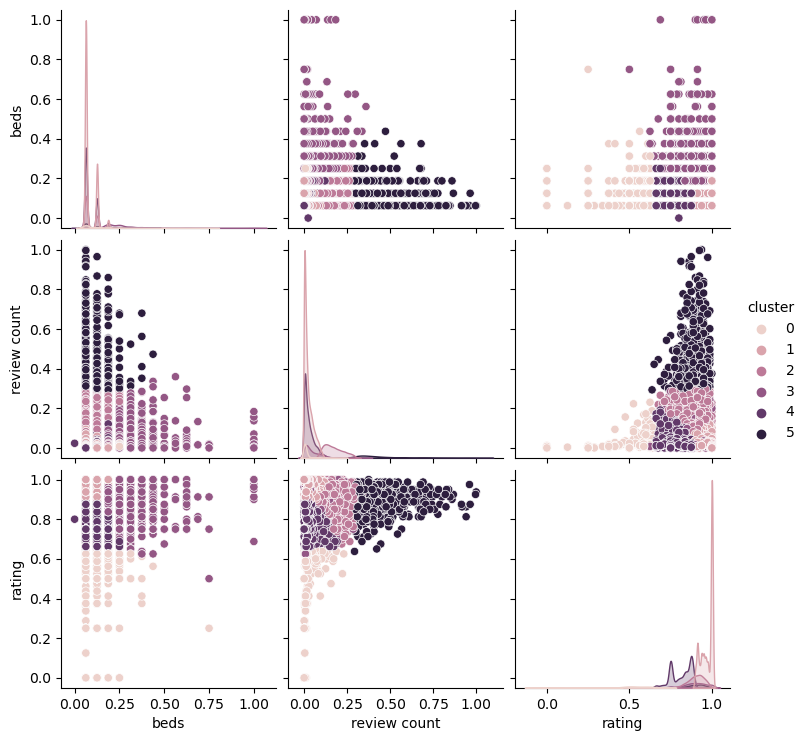

In [8]:
# Used solution for this line, as I did not know how to get the clusters to show up as different colors
cluster_data['cluster'] = model.labels_
sns.pairplot(data=cluster_data,hue='cluster')

5. Use `.groupby` and `.describe` to compute the average price for each cluster. Which clusters have the highest rental prices?

In [9]:
# going back to adf that includes Price
adf['cluster'] = model.labels_
adf.loc[:,['price','cluster']].groupby('cluster').describe()

price                                                             
           count        mean         std   min    25%    50%     75%      max
cluster                                                                      
0          632.0  133.587025  215.505565  25.0   65.0   99.0  151.25   5000.0
1        10529.0  152.287682  147.227153  10.0   85.0  130.0  190.00  10000.0
2         3022.0  141.489411   83.936285  22.0   87.0  125.0  175.00   1000.0
3         1626.0  293.528905  262.934691  27.0  150.0  229.0  350.00   4500.0
4         5554.0  131.631797  102.758887  20.0   75.0  110.0  169.00   5000.0
5          792.0  133.224747   83.088608  27.0   80.0  110.0  167.50    875.0

> Cluster 3 has the highest mean rental price at 293 a night, which is almost double the next nearest cluster. After that, cluster 1 and 2 are the highest, with clusters 0, 4, and 5 being roughly the same

6. Use a scree plot to pick the number of clusters and repeat steps 4 and 5.

Text(0.5, 1.0, 'Scree Plot')

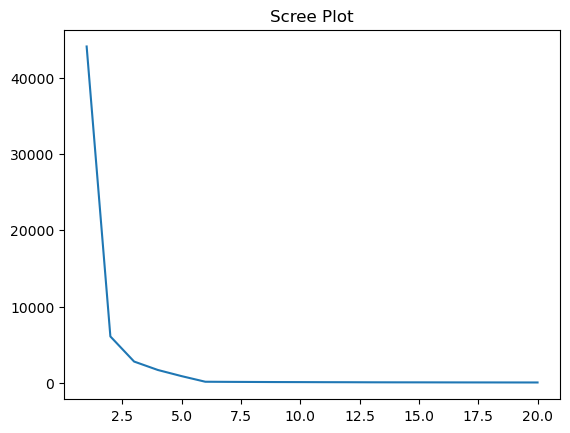

In [13]:
k_bar = 20
k_grid = np.arange(1,k_bar+1) # creates int list of values from 1 to k
SSE = np.zeros(k_bar)

for k in range(k_bar):
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0)
    fitted_model = model.fit(cluster_data)
    SSE[k] = fitted_model.inertia_
    
# Makes the scree plot
sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot')

> elbow is 2 or 3, but change from 2-3 is still large compared to change from 3-4, so will use 3 clusters.

C:\Users\taran\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


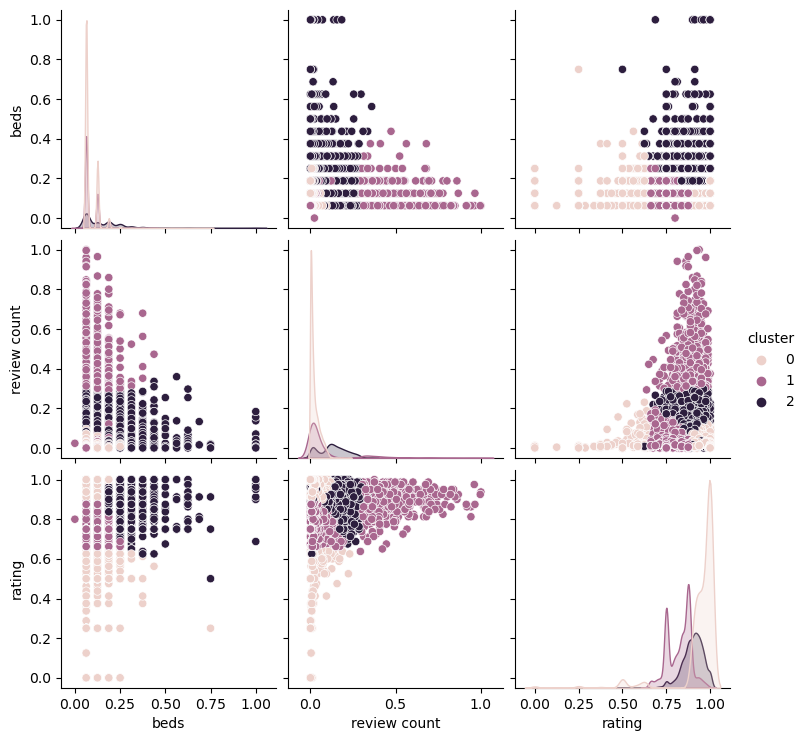

In [14]:
# Creates KMeans model with k=3 and fits it to cluster_data
model = KMeans(n_clusters=3, max_iter=300, n_init = 10, random_state=0).fit(cluster_data)

cluster_data['cluster'] = model.labels_
sns.pairplot(data=cluster_data,hue='cluster')

In [15]:
# going back to adf that includes Price
adf['cluster'] = model.labels_
adf.loc[:,['price','cluster']].groupby('cluster').describe()

price                                                           
           count        mean         std   min   25%    50%    75%      max
cluster                                                                    
0        11161.0  151.228743  151.963553  10.0  85.0  129.0  190.0  10000.0
1         6346.0  131.830602  100.510035  20.0  75.0  110.0  169.0   5000.0
2         4648.0  194.677065  184.430237  22.0  99.0  150.0  225.0   4500.0

> Cluster 0 is the largest and has the highest spread of data (10-10000). The average prices are a lot more similar across the clusters now. Cluster 0 has the least amount of beds in general and the least nmber of reviews, which is likely why the rating spread is so large. Cluster 1 has the highest review count and a low number of beds similar to cluster 0, but a lower average price. On the other hand, cluster 2 is the most expensive and has the most beds. While there are less reviews than cluster 1, they are scored high.

**Q2.** This is a question about $k$ means clustering. We want to investigate how adjusting the "noisiness" of the data impacts the quality of the algorithm and the difficulty of picking $k$.

1. Run the code below, which creates four datasets: `df0_125`, `df0_25`, `df0_5`, `df1_0`, and `df2_0`. Each data set is created by increasing the amount of `noise` (standard deviation) around the cluster centers, from `0.125` to `0.25` to `0.5` to `1.0` to `2.0`.

In [16]:
def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)

2. Make scatterplots of the $(X1,X2)$ points by group for each of the datasets. As the `noise` goes up from 0.125 to 2.0, what happens to the visual distinctness of the clusters?

<Axes: xlabel='x1', ylabel='x2'>

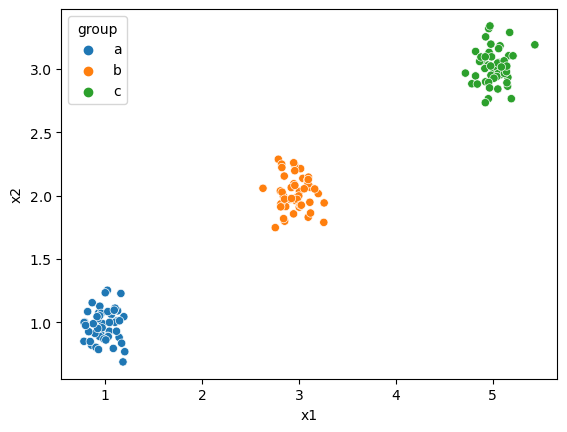

In [22]:
sns.scatterplot(data=df0_125,x='x1',y='x2',hue='group')

<Axes: xlabel='x1', ylabel='x2'>

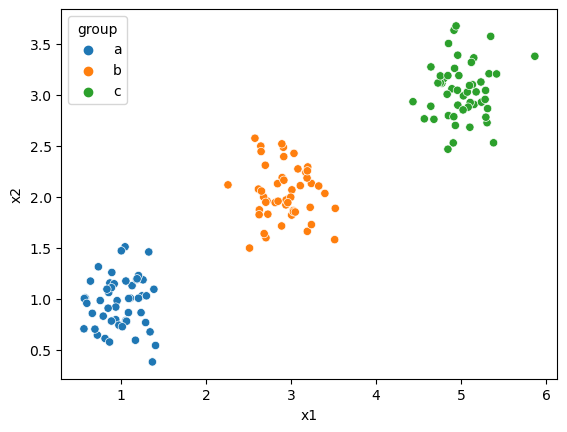

In [23]:
sns.scatterplot(data=df0_25,x='x1',y='x2',hue='group')

<Axes: xlabel='x1', ylabel='x2'>

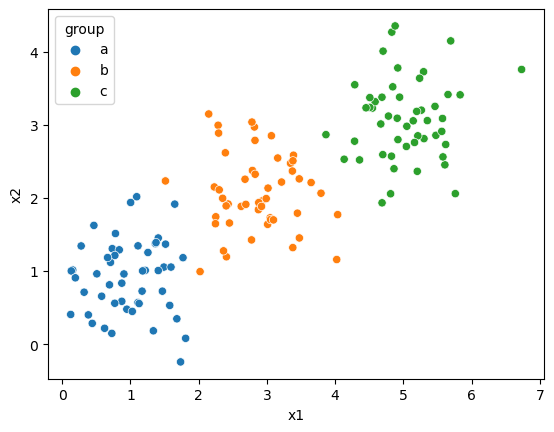

In [24]:
sns.scatterplot(data=df0_5,x='x1',y='x2',hue='group')

<Axes: xlabel='x1', ylabel='x2'>

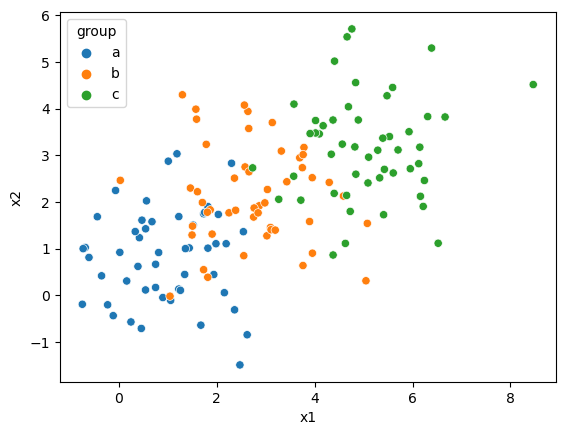

In [25]:
sns.scatterplot(data=df1_0,x='x1',y='x2',hue='group')

<Axes: xlabel='x1', ylabel='x2'>

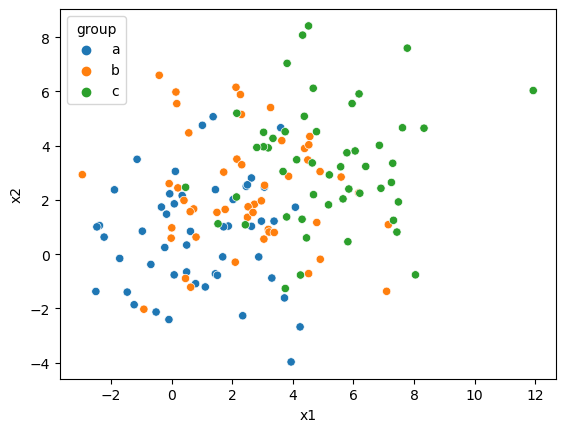

In [26]:
sns.scatterplot(data=df2_0,x='x1',y='x2',hue='group')

> as the noise increases, the visual distinctiveness of the clusters decrease. The data becomes more spread out and the clusters overlap more and more.

3. Create a scree plot for each of the datasets. Describe how the level of `noise` affects the scree plot (particularly the presence of a clear "elbow") and your ability to definitively select a $k$.

In [32]:
# was getting a bunch of warning messages about memory leaks but code still executed, seems to be correct, so supressed warnings for now
import warnings
warnings.filterwarnings('ignore')

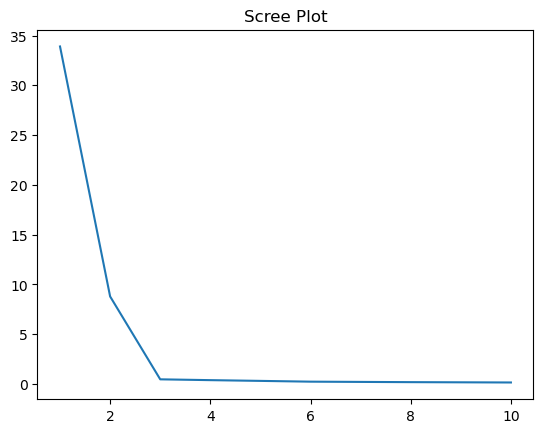

In [31]:
def screecreate(data):
    # select and normalize the data
    selected_data = data.loc[:,['x1','x2']].apply(maxmin)
    
    # create the model with k_bar values for k
    k_bar = 10
    k_grid = np.arange(1,k_bar+1) # creates int list of values from 1 to k
    SSE = np.zeros(k_bar)

    for k in range(k_bar):
        model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0)
        fitted_model = model.fit(selected_data)
        SSE[k] = fitted_model.inertia_

    # Makes the scree plot
    sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot')
    
screecreate(data=df0_125)

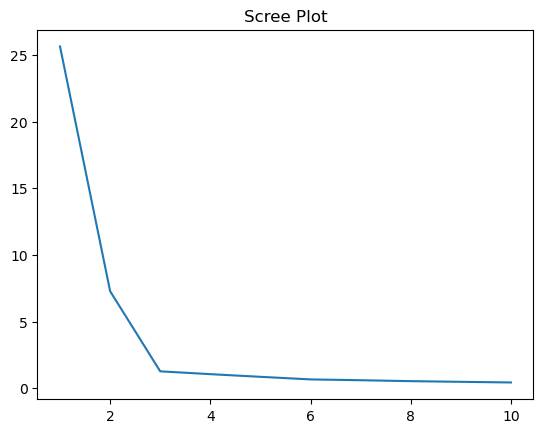

In [33]:
screecreate(data=df0_25)

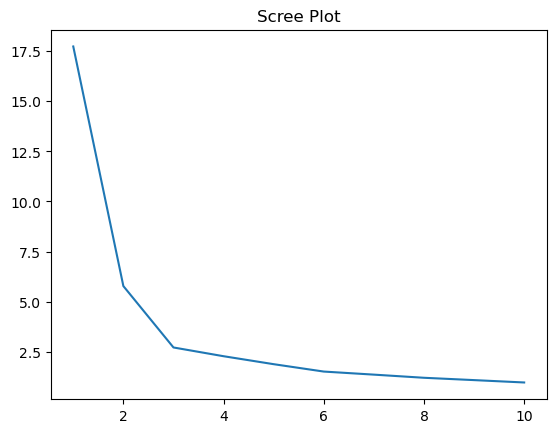

In [34]:
screecreate(data=df0_5)

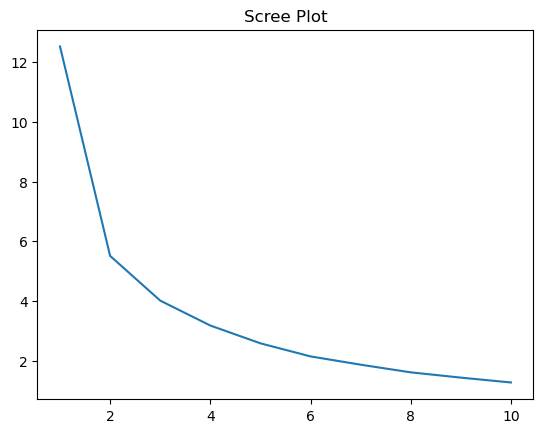

In [35]:
screecreate(data=df1_0)

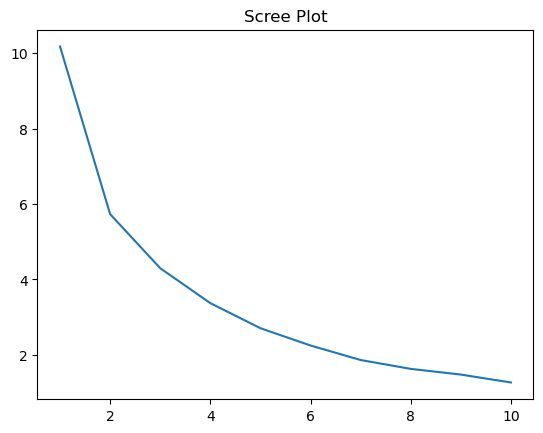

In [36]:
screecreate(data=df2_0)

> as the noise increases, the appearance of an elbow decreases as the graph becomes smoother. At low noise (<=0.5), the elbow is visible and picking k=3 seems reasonable and agreeable. At and above 0.5, the elbow becomes harder to distinguish, meaning it is harder to recover any specific clustering behavior, which makes sense with noiser, overlapping data.

4. Explain the intuition of the elbow, using this numerical simulation as an example.

> Groups with low noise and seperation allow for KMeans to recover the grouping of the data. The elbow is the number of clusters that shows the biggest change in SSE in relation to the number of clusters present (in other words, look at the derivative aka rate of change). Increasing the number of clusters will always (I think?) reduce the SSE, but may not accurately represent the group data that is trying to be recovered/discovered. This is apparent through this example, where data with high noise, and thus less grouping and more overlap, had less of an elbow visbile on the skree plot since it is harder for the algorithm to pick up on any patterns in x1/x2 and the associated value. With scrambled data, the elbow is not apparent since the rate of change of the SSE is not drastic beacuse there is no distinct grouping.